# <h1 style="text-align: center;">Optimal Control of TCLab using a Gaussian process regression embedded in Pyomo - notebook v5</h1>

<p style="text-align: center;">Alex Dowling<sup>a</sup>, Jacob P. Krell<sup>b</sup>, David S. Mebane<sup>b</sup>

<p style="text-align: center;"><sup>a</sup>Department of Chemical and Biomolecular Engineering, University of Notre Dame, Notre Dame, IN 46556, USA <br>
<sup>b</sup>Department of Mechanical and Aerospace Engineering, West Virginia University, Morgantown, WV, 26506-6106, USA</p>

## Method

- fit GP to raw data as a smoothing function
- take derivative of smoothed data, which is possible via chain rule of GP analytic gradient
- fit GP to derivative, which is the "GP Model" of TCLab
- integrate GP to validate model of derivative

## Setup

In [2]:
import os
dir = os.path.abspath('')  # directory of notebook
import pandas as pd
import numpy as np
from FoKL import FoKLRoutines
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Load and parse data:

In [81]:
filename = "tclab_sine_test.csv"
data = pd.read_csv(os.path.join(dir, filename))

tvec = data["Time"].values
Q1 = data["Q1"].values
TS1 = data["T1"].values

Define heater power control signal:

In [101]:
Q1f = interp1d(tvec, Q1, kind='previous')  # piecewise Q1
dQ1f_analytic = lambda t: 1500 * np.cos(30 * np.pi * t / tvec[-1]) * np.pi / tvec[-1]  # derivative of analytic Q1
dQ1f = interp1d(tvec, dQ1f_analytic(tvec), kind='previous')  # piecewise derivative of analytic Q1

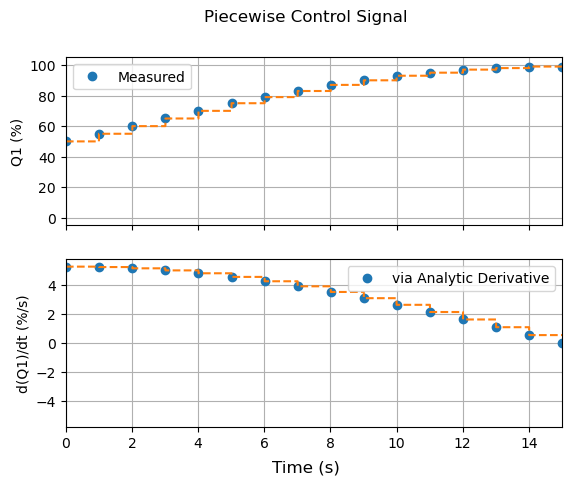

In [104]:
tvec_ub = tvec[1::] - 1e-3  # upper bounds for piecewise plots
tvec_piecewise = [tvec[0]]
for i in range(len(tvec_ub)):
    tvec_piecewise += [tvec_ub[i], tvec[i + 1]]
tvec_piecewise = np.array(tvec_piecewise)

fig, axs = plt.subplots(2, 1, sharex=True)
fig.suptitle("Piecewise Control Signal")
fig.supxlabel("Time (s)")

axs[0].plot(tvec, Q1, 'o')
axs[0].plot(tvec_piecewise, Q1f(tvec_piecewise), '--')
axs[0].set_ylabel("Q1 (%)")
axs[0].set_xlim([0, tvec[-1] / 15 / 4])
axs[0].legend(["Measured"])
axs[0].grid()

axs[1].plot(tvec, dQ1f_analytic(tvec), 'o')
axs[1].plot(tvec_piecewise, dQ1f(tvec_piecewise), '--')
axs[1].set_ylabel("d(Q1)/dt (%/s)")
axs[1].set_xlim([0, tvec[-1] / 15 / 4])
axs[1].legend(["via Analytic Derivative"])
axs[1].grid()

## Benchmark

Predicting temperatures via the two-state ODE,

In [84]:
alpha = 0.00016                                                                     # watts / (units P1 * percent U1)
P1 = 200                                                                            # P1 units
T_amb = TS1[0]  # ambient temperature

IC = [T_amb, T_amb]  # initial condition of states [TH1, TS1]
CpH =  7.006         # J/degC
CpS = 0.01           # J/degC
Ua =  0.051          # W/degC
Ub =  0.001          # W/degC

In [85]:
def dy_benchmark(t, y):
    """Benchmark ODE, for TS1."""
    TH1, TS1 = y
    dTH1 = (Ua * (T_amb - TH1) + Ub * (TS1 - TH1) + alpha * P1 * Q1f(t)) / CpH
    dTS1 = Ub * (TH1 - TS1) / CpS
    return [dTH1, dTS1]

soln_benchmark = solve_ivp(dy_benchmark, [tvec[0], tvec[-1]], IC, t_eval=tvec)

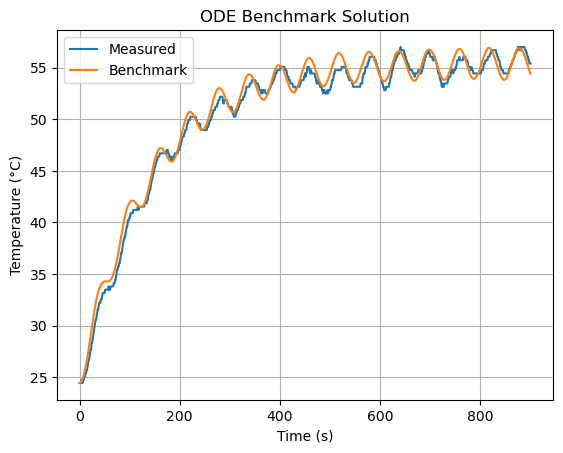

In [86]:
TS1_benchmark = soln_benchmark.y[1]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_benchmark)
plt.grid()
plt.title('ODE Benchmark Solution')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Measured', 'Benchmark'])

## Derivative of Smoothed Data

Since raw measurements are noisy, a smoothing functions is applied before calculating the time derivative.

### Smoothing

Using a GP as the smoothing function,

In [87]:
GP_T = FoKLRoutines.FoKL(kernel=1, UserWarnings=False)
_ = GP_T.fit([tvec, Q1], TS1, clean=True)

[1, 3592.127247512837]
[2, 3587.245251431803]
[2, 2325.6195698812176]
[3, 2307.576809156444]
[3, 574.1060402705099]
[4, 574.1060402705099]
[4, 540.9138514384176]
[4, -331.62357408654935]
[5, -331.62357408654935]
[5, -331.62357408654935]
[5, -384.5296810595524]
[6, -384.5296810595524]
[6, -384.5296810595524]
[6, -391.2268172424733]
[6, -394.6888620369673]
[7, -394.6888620369673]
[7, -394.6888620369673]
[7, -390.73500263956225]


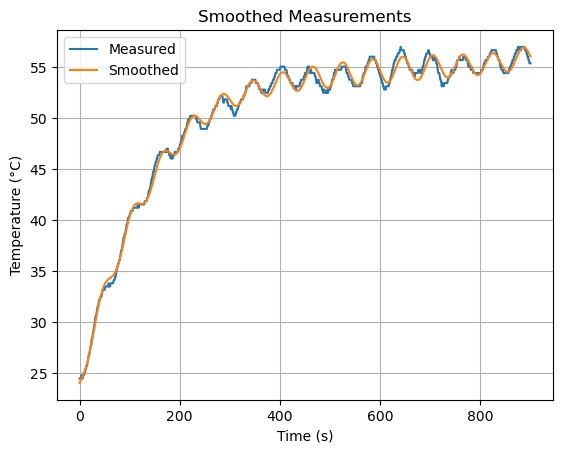

In [88]:
TS1_smooth = GP_T.evaluate()

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_smooth)
plt.grid()
plt.title('Smoothed Measurements')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Measured', 'Smoothed'])

### Derivative

Applying the chain rule to obtain training data,

In [105]:
dGP = GP_T.bss_derivatives()  # gradient of GP_T

dGPdt = interp1d(tvec, dGP[:, 0])
dGPdQ1 = interp1d(Q1, dGP[:, 1])
dTS1f = lambda t: dGPdt(t) + dGPdQ1(Q1f(t)) * dQ1f(t)  # interpolation function

dTS1 = dTS1f(tvec)  # evaluate interpolation function at tvec to form training data

Validating training data:

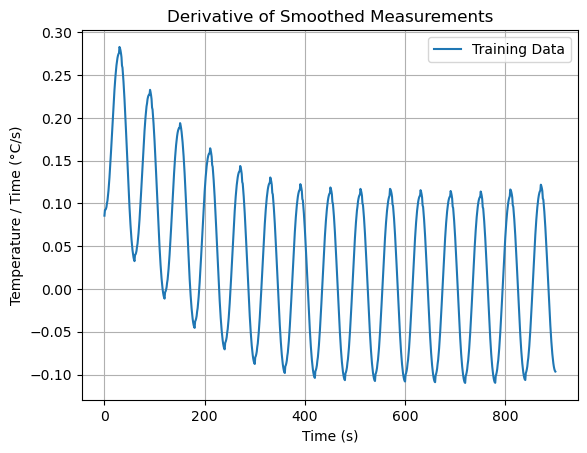

In [106]:
%matplotlib inline
plt.figure()
plt.plot(tvec, dTS1)
plt.title('Derivative of Smoothed Measurements')
plt.xlabel('Time (s)')
plt.ylabel('Temperature / Time (°C/s)')
plt.legend(['Training Data'])
plt.grid()

In [107]:
def dy_training(t, y):
    """ODE to integrate GP's training data'."""
    return [dTS1f(t)]

soln_training = solve_ivp(dy_training, [tvec[0], tvec[-1]], [TS1_smooth[0]], t_eval=tvec)

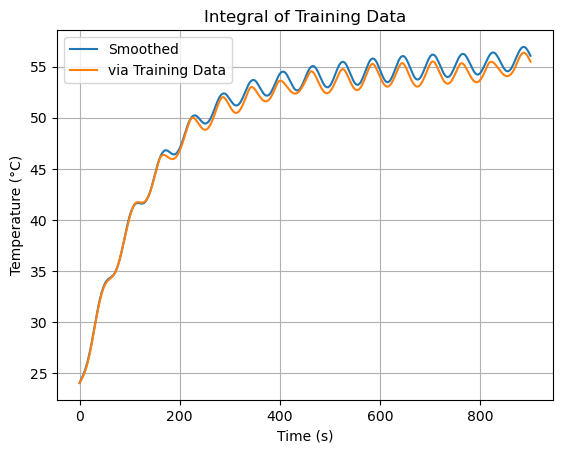

In [108]:
TS1_training = soln_training.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.grid()
plt.title('Integral of Training Data')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Smoothed', 'via Training Data'])

## GP Model of Derivative

### Optimal Lag Time

In [118]:
GPs_dT = [FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True)]
print("Training with no lag:")
GPs_dT[0].fit([TS1, Q1], dTS1, clean=True)

dt = tvec[1] - tvec[0]  # fixed time step
for i in range(1, 9):
    GPs_dT.append(FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True))
    print(f"\nTraining with lag of {i} time steps:")
    GPs_dT[i].fit([TS1[i::], Q1f(tvec[:-i])], dTS1[i::], clean=True)

Training with no lag:
[1, -3643.4041280177344]
[2, -3641.84754743581]
[2, -3640.569642617431]
[3, -3637.9791080158266]

Training with lag of 1 time steps:
[1, -3638.1977816790004]
[2, -3636.5827217164488]
[2, -3636.72082231072]
[3, -3634.9431407897328]

Training with lag of 2 time steps:
[1, -3652.589105146115]
[2, -3650.9099184316574]
[2, -3652.9825713713344]
[3, -3652.301353239359]
[3, -3703.0496739462706]
[4, -3708.1593631444002]
[4, -3708.1593631444002]
[4, -3719.0736157738766]
[5, -3733.990648922205]
[5, -3733.990648922205]
[5, -3789.899677598367]
[6, -3789.899677598367]
[6, -3805.170411204542]
[6, -3809.2104714580164]
[6, -3807.214242930535]
[7, -3807.214242930535]
[7, -3811.2310918332905]
[7, -3811.2310918332905]
[7, -3816.839985291148]
[8, -3816.839985291148]
[8, -3816.839985291148]
[8, -3816.839985291148]

Training with lag of 3 time steps:
[1, -3687.032495575122]
[2, -3687.032495575122]
[2, -3687.795095881299]
[3, -3689.0962196415376]
[3, -3749.4034469246]
[4, -3754.210040090

In [126]:
def _plot_GPs_dT(GPs_dT, dTS1_GPs=[], i0=0):
    %matplotlib inline
    fig, axs = plt.subplots(3, 3)
    fig.suptitle('Derivative of Smoothed Measurements, GP Model')
    fig.supxlabel('Time (s)')
    fig.supylabel('Temperature / Time (°C/s)')

    i = i0 - 1
    for j in range(3):
        for k in range(3):
            i += 1
            dTS1_GPs.append(GPs_dT[i].evaluate())
            
            axs[j, k].plot(tvec, dTS1)
            axs[j, k].plot(tvec[i::], dTS1_GPs[i])
            axs[j, k].set_title(f"Lag = {i} dt")
            axs[j, k].grid()
    fig.tight_layout()

    return dTS1_GPs

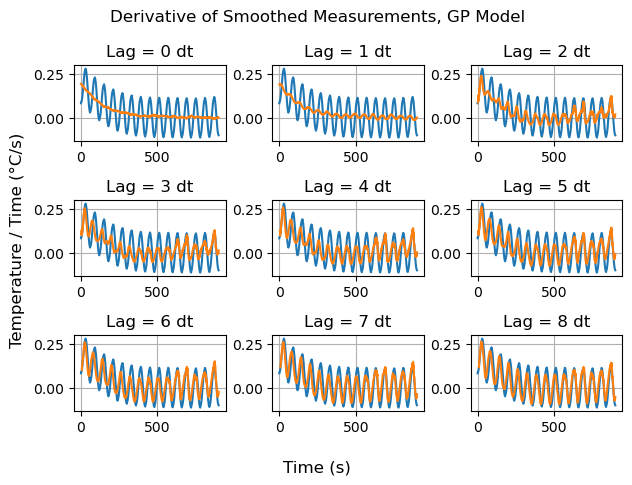

In [127]:
dTS1_GPs = _plot_GPs_dT(GPs_dT)

Repeat:

In [128]:
for i in range(9, 18):
    GPs_dT.append(FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True))
    print(f"\nTraining with lag of {i} time steps:")
    GPs_dT[i].fit([TS1[i::], Q1f(tvec[:-i])], dTS1[i::], clean=True)


Training with lag of 9 time steps:
[1, -4399.223049383756]
[2, -4399.223049383756]
[2, -4413.123119260926]
[3, -4418.056039348893]
[3, -4550.541765262431]
[4, -4565.088770313584]
[4, -4565.088770313584]
[4, -4608.835301277741]
[5, -4641.220517330007]
[5, -4641.220517330007]
[5, -4706.464095531425]
[6, -4706.464095531425]
[6, -4715.979911636756]
[6, -4715.810631605586]
[6, -4724.063071920648]
[7, -4724.063071920648]
[7, -4723.585364565376]
[7, -4723.585364565376]

Training with lag of 10 time steps:
[1, -4638.81506022234]
[2, -4638.81506022234]
[2, -4653.371001527516]
[3, -4658.861868911278]
[3, -4801.028758927868]
[4, -4817.024168873025]
[4, -4817.024168873025]
[4, -4864.924203411199]
[5, -4897.52802695974]
[5, -4897.52802695974]
[5, -4964.599649143017]
[6, -4964.599649143017]
[6, -4972.780721822371]
[6, -4972.156106406793]
[6, -4983.157848456085]
[7, -4983.157848456085]
[7, -4982.346680532576]
[7, -4982.346680532576]

Training with lag of 11 time steps:
[1, -4937.3439013889365]
[2, -

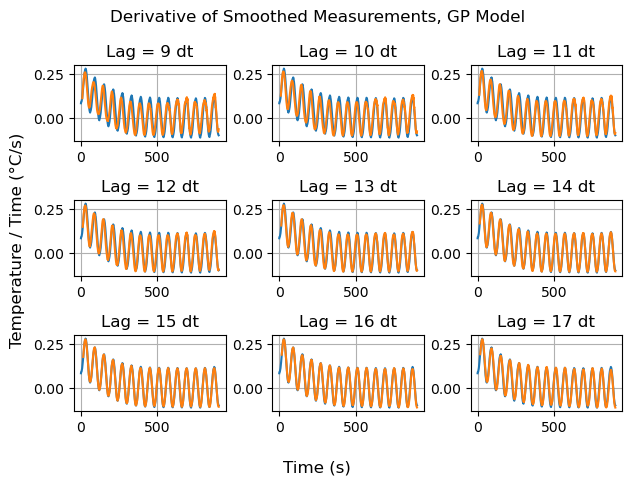

In [129]:
dTS1_GPs = _plot_GPs_dT(GPs_dT, dTS1_GPs, 9)

Repeat:

In [130]:
for i in range(18, 27):
    GPs_dT.append(FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True))
    print(f"\nTraining with lag of {i} time steps:")
    GPs_dT[i].fit([TS1[i::], Q1f(tvec[:-i])], dTS1[i::], clean=True)


Training with lag of 18 time steps:
[1, -6002.773619412622]
[2, -6002.347220948223]
[2, -6042.382885904318]
[3, -6048.475923644023]
[3, -6064.300210733291]
[4, -6071.796326660145]
[4, -6072.155939830734]
[4, -6071.762757609728]
[5, -6093.306287986353]
[5, -6097.579546605248]
[5, -6113.761763754638]
[6, -6113.761763754638]
[6, -6114.717406952639]
[6, -6112.721656761816]
[6, -6117.228665113245]
[7, -6117.228665113245]
[7, -6130.835908866009]
[7, -6130.835908866009]
[7, -6139.009295846043]
[8, -6139.009295846043]
[8, -6139.009295846043]
[8, -6140.950081227031]
[8, -6140.950081227031]
[8, -6164.666561648986]
[9, -6164.666561648986]
[9, -6164.666561648986]
[9, -6164.666561648986]

Training with lag of 19 time steps:
[1, -5423.929636982568]
[2, -5422.802071562768]
[2, -5452.425839989038]
[3, -5458.178539751721]
[3, -5484.222791877808]
[4, -5492.295963908199]
[4, -5492.749094586875]
[4, -5490.006720660798]
[5, -5511.094859462817]
[5, -5520.211183766836]
[5, -5539.009300878764]
[6, -5539.0093

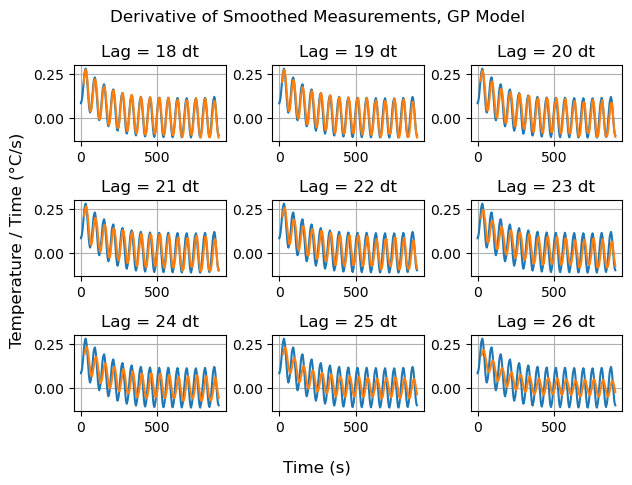

In [131]:
dTS1_GPs = _plot_GPs_dT(GPs_dT, dTS1_GPs, 18)

Repeat:

In [132]:
for i in range(27, 36):
    GPs_dT.append(FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True))
    print(f"\nTraining with lag of {i} time steps:")
    GPs_dT[i].fit([TS1[i::], Q1f(tvec[:-i])], dTS1[i::], clean=True)


Training with lag of 27 time steps:
[1, -3656.791841846458]
[2, -3656.791841846458]
[2, -3655.1976797316647]
[3, -3655.1976797316647]

Training with lag of 28 time steps:
[1, -3590.5571579382477]
[2, -3590.5571579382477]
[2, -3589.496700496141]
[3, -3589.496700496141]

Training with lag of 29 time steps:
[1, -3545.5292863971154]
[2, -3543.841494293373]
[2, -3544.9188422646275]
[3, -3544.9188422646275]

Training with lag of 30 time steps:
[1, -3520.6310191496323]
[2, -3519.0599689426354]
[2, -3523.393857058436]
[3, -3523.393857058436]
[3, -3535.5399341361417]
[4, -3537.4120682038756]
[4, -3538.0351203909795]
[4, -3590.1613645367934]
[5, -3596.4232178494276]
[5, -3596.4232178494276]
[5, -3594.437880072289]
[6, -3594.437880072289]

Training with lag of 31 time steps:
[1, -3515.50919273992]
[2, -3514.058911215355]
[2, -3522.530113956307]
[3, -3521.1743584472097]
[3, -3543.0897870170074]
[4, -3552.02339668666]
[4, -3555.086809864957]
[4, -3613.9374012276376]
[5, -3622.767454289601]
[5, -36

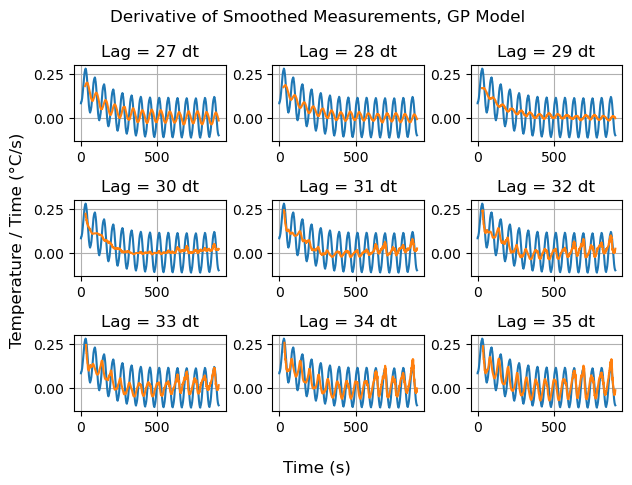

In [133]:
dTS1_GPs = _plot_GPs_dT(GPs_dT, dTS1_GPs, 27)

Now that GP models are trained for various lag times, the error of each may be evaluated.

In [134]:
def _rmse(targets, predictions):
    return np.sqrt(np.mean((predictions - targets) ** 2))

In [139]:
RMSEs = []
for i in range(len(dTS1_GPs)):
    RMSEs.append(_rmse(dTS1[i::], dTS1_GPs[i]))

i_opt = np.argmin(RMSEs)  # optimal lag
print(f"Optimal Lag:\n\n\
       i = {i_opt}\n\
     Lag = i*dt = {i_opt * dt} s\n\
    RMSE = {RMSEs[i_opt]} °C")

Optimal Lag:

       i = 15
     Lag = i*dt = 15.0 s
    RMSE = 0.005166419524852379 °C


Defining GP model as the one trained with the optimal lag:

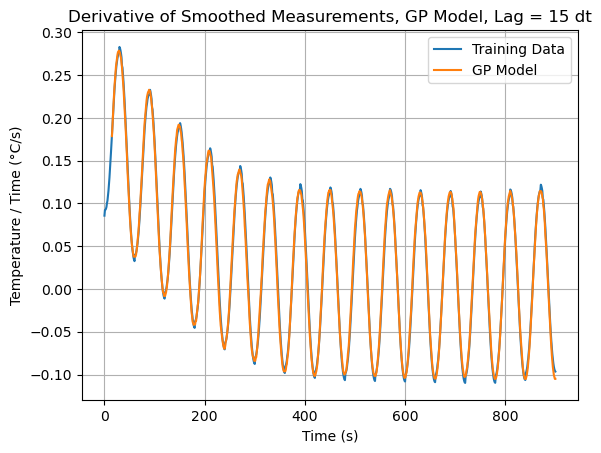

In [164]:
GP_dT = GPs_dT[i_opt]
dTS1_GP = dTS1_GPs[i_opt]  # == GP_dT.evaluate()

%matplotlib inline
plt.figure()
plt.plot(tvec, dTS1)
plt.plot(tvec[i_opt::], dTS1_GP)
plt.title(f"Derivative of Smoothed Measurements, GP Model, Lag = {i_opt} dt")
plt.xlabel('Time (s)')
plt.ylabel('Temperature / Time (°C/s)')
plt.legend(['Training Data', 'GP Model'])
plt.grid()

### Integration

In [144]:
def dy_GP(t, y):
    """ODE to integrate GP of derivative."""
    return [GP_dT.evaluate([y[0], Q1f(t - i_opt * dt)], clean=True, SingleInstance=True)[0]]

soln_GP = solve_ivp(dy_GP, [tvec[i_opt], tvec[-1]], [TS1_smooth[i_opt]], 'LSODA', tvec[i_opt::])

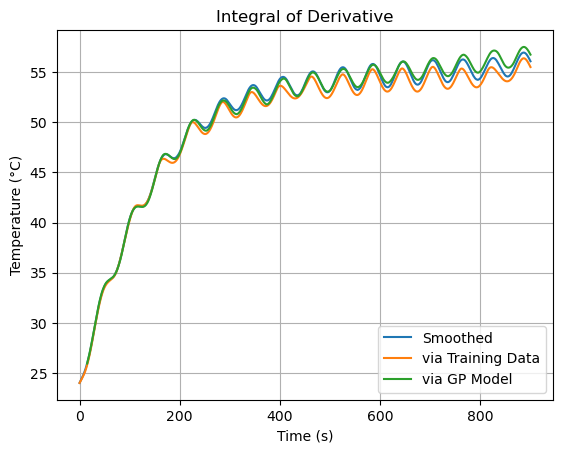

In [145]:
TS1_dGP = soln_GP.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.plot(tvec[i_opt::], TS1_dGP)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via Training Data', 'via GP Model'])
plt.grid()

Repeat, but with fixed time step:

In [147]:
soln_GP_fixed_dt = solve_ivp(dy_GP, [tvec[i_opt], tvec[-1]], [TS1_smooth[i_opt]], 'LSODA', tvec[i_opt::], first_step=1, min_step=1, max_step=1)

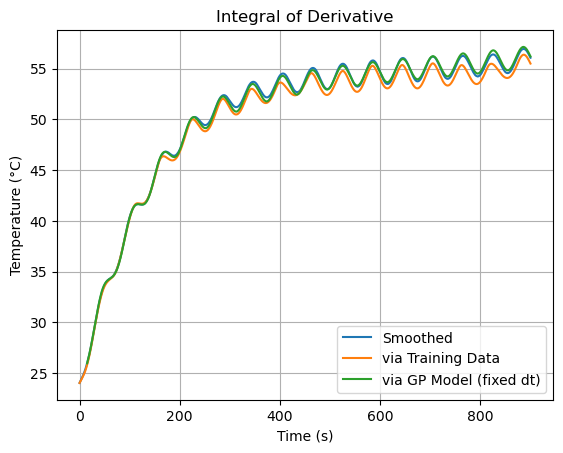

In [148]:
TS1_dGP_fixed_dt = soln_GP_fixed_dt.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via Training Data', 'via GP Model (fixed dt)'])
plt.grid()

### Comparison of Variable $\Delta t$ vs. Fixed $\Delta t$

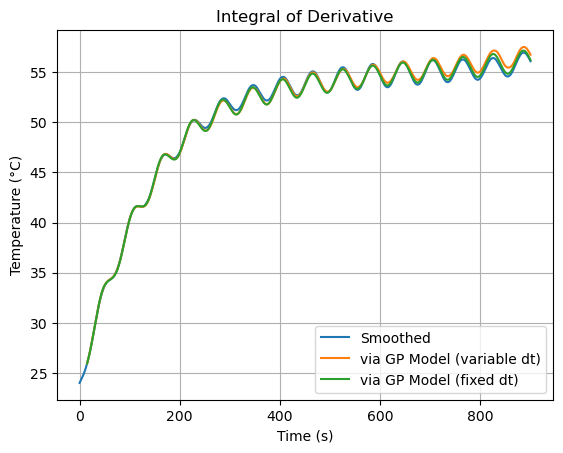

Comparison of Variable dt vs. Fixed dt:

    | Timestep | RMSE (°C) |
    |----------|-----------|
    | Variable | 0.3539508 |
    | Fixed    | 0.2026400 |


In [162]:
RMSE_dGP = _rmse(TS1_smooth[i_opt::], TS1_dGP)
RMSE_dGP_fixed_dt = _rmse(TS1_smooth[i_opt::], TS1_dGP_fixed_dt)

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec[i_opt::], TS1_dGP)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via GP Model (variable dt)', 'via GP Model (fixed dt)'])
plt.grid()
plt.show()

print(f"Comparison of Variable dt vs. Fixed dt:\n\n\
    | Timestep | RMSE (°C) |\n\
    |----------|-----------|\n\
    | Variable | {"{0:0.7f}".format(round(RMSE_dGP, 7))} |\n\
    | Fixed    | {"{0:0.7f}".format(round(RMSE_dGP_fixed_dt, 7))} |")

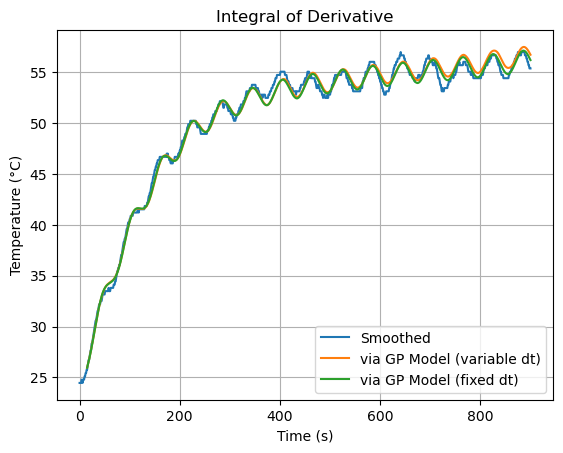

Comparison of Variable dt vs. Fixed dt:

    | Timestep | RMSE (°C) |
    |----------|-----------|
    | Variable | 0.6066471 |
    | Fixed    | 0.4996014 |


In [166]:
RMSE_dGP_raw = _rmse(TS1[i_opt::], TS1_dGP)
RMSE_dGP_fixed_dt_raw = _rmse(TS1[i_opt::], TS1_dGP_fixed_dt)

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec[i_opt::], TS1_dGP)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via GP Model (variable dt)', 'via GP Model (fixed dt)'])
plt.grid()
plt.show()

print(f"Comparison of Variable dt vs. Fixed dt:\n\n\
    | Timestep | RMSE (°C) |\n\
    |----------|-----------|\n\
    | Variable | {"{0:0.7f}".format(round(RMSE_dGP_raw, 7))} |\n\
    | Fixed    | {"{0:0.7f}".format(round(RMSE_dGP_fixed_dt_raw, 7))} |")

## GP Model of Residual

- targets: smoothed data
- predictions: fixed timestep

In [169]:
res = TS1_smooth[i_opt::] - TS1_dGP_fixed_dt

GP_res = FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True)
_ = GP_res.fit(tvec[i_opt::], res, clean=True)

[1, -2277.421315998751]
[2, -2993.622582582231]
[3, -3109.0444881323133]
[4, -3383.591322458731]
[5, -3389.8093534297086]
[6, -3395.967918945472]
[7, -3584.841419507755]
[8, -3592.4513721783132]
[9, -3615.969457315754]
[10, -3628.1364324369033]
[11, -3644.2267782975587]
[12, -3644.2267782975587]
[13, -3644.783610876738]
[14, -3644.783610876738]
[15, -3644.783610876738]
[16, -3644.783610876738]


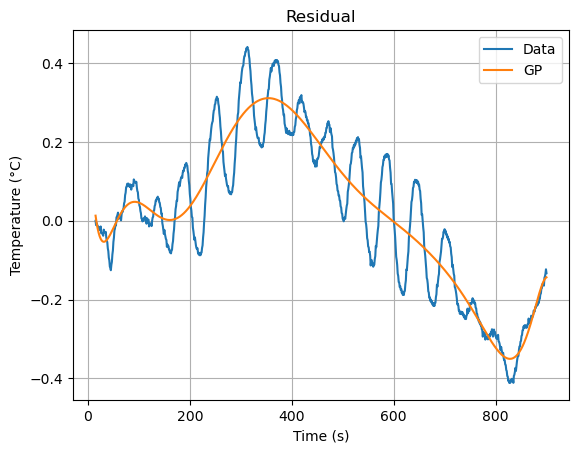

In [170]:
res_GP = GP_res.evaluate()

%matplotlib inline
plt.figure()
plt.plot(tvec[i_opt::], res)
plt.plot(tvec[i_opt::], res_GP)
plt.title('Residual')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Data', 'GP'])
plt.grid()
plt.show()

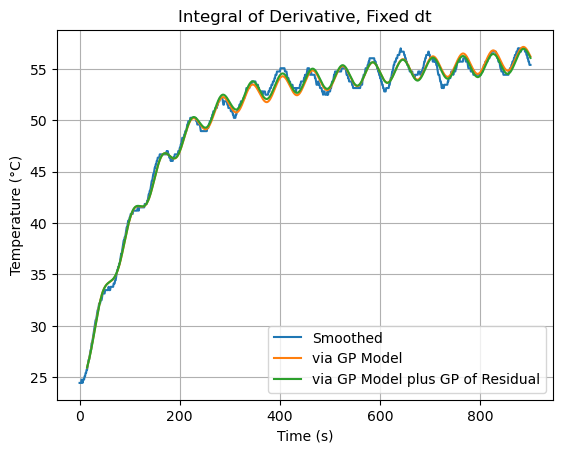

In [171]:
TS1_dGP_fixed_dt_plus_res = TS1_dGP_fixed_dt + res_GP

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt_plus_res)
plt.title('Integral of Derivative, Fixed dt')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via GP Model', 'via GP Model plus GP of Residual'])
plt.grid()
plt.show()

Repeat, but with raw data:

In [172]:
res_raw = TS1[i_opt::] - TS1_dGP_fixed_dt

GP_res_raw = FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True)
_ = GP_res_raw.fit(tvec[i_opt::], res_raw, clean=True)

[1, -388.0479031282921]
[2, -446.3277552950028]
[3, -453.32152175639203]
[4, -458.7126403274733]
[5, -458.7126403274733]
[6, -458.7126403274733]
[7, -458.7126403274733]


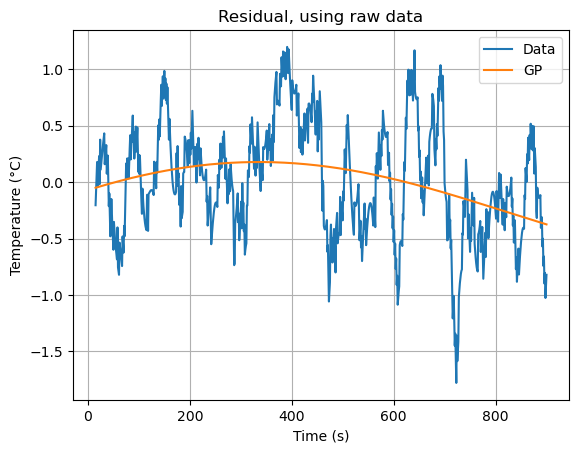

In [173]:
res_GP_raw = GP_res_raw.evaluate()

%matplotlib inline
plt.figure()
plt.plot(tvec[i_opt::], res_raw)
plt.plot(tvec[i_opt::], res_GP_raw)
plt.title('Residual, using raw data')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Data', 'GP'])
plt.grid()
plt.show()

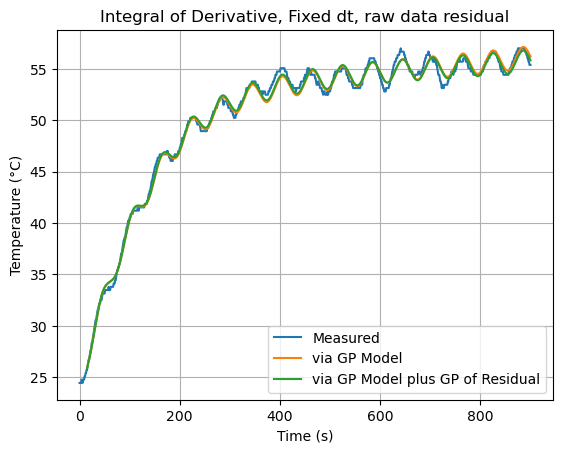

In [174]:
TS1_dGP_fixed_dt_plus_res_raw = TS1_dGP_fixed_dt + res_GP_raw

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt_plus_res_raw)
plt.title('Integral of Derivative, Fixed dt, raw data residual')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Measured', 'via GP Model', 'via GP Model plus GP of Residual'])
plt.grid()
plt.show()

## Benchmark Comparison

Since the residual, modeled only with $t$, does not seem to provide significant improvement, the integrated GP at fixed timestep will be considered the predictions.

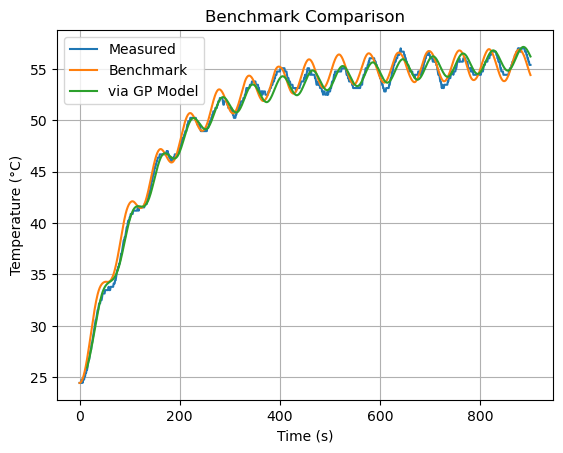

Benchmark Comparison:

    | Method                                 | RMSE (°C) |
    |----------------------------------------|-----------|
    | Benchmark (ODE)                        | 0.8116180 |
    | GP (piecewise Q1, lagged Q1, fixed dt) | 0.2026400 |


In [180]:
%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_benchmark)
plt.plot(tvec[i_opt::], TS1_dGP_fixed_dt)
plt.title('Benchmark Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Measured', 'Benchmark', 'via GP Model'])
plt.grid()
plt.show()

RMSE_benchmark = _rmse(TS1, TS1_benchmark)
print(f"Benchmark Comparison:\n\n\
    | Method                                 | RMSE (°C) |\n\
    |----------------------------------------|-----------|\n\
    | Benchmark (ODE)                        | {"{0:0.7f}".format(round(RMSE_benchmark, 7))} |\n\
    | GP (piecewise Q1, lagged Q1, fixed dt) | {"{0:0.7f}".format(round(RMSE_dGP_fixed_dt, 7))} |")